In [7]:
from pycalphad import Database, variables as v

In [27]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'ZN', 'VA']
temp_range = (300, 1700, 1)

In [275]:
dbf.symbols['GHSERZN'].args

(-7285.787 + 118.470069*T - 23.701314*T*log(T) - 0.001712034*T**2 - 1.264963e-06*T**3,
 And(T < 692.68, 298.15 <= T),
 -11070.559 + 172.34566*T - 31.38*T*log(T) + 4.70514e+26*T**(-9),
 And(T < 3000.0, 692.68 <= T),
 0,
 True)

In [342]:
import tensorflow as tf
def function_to_tf(sym):
    # Only works with SymEngine-based branch of pycalphad
    args = sym.args
    chunked_args = [args[x:x+2] for x in range(0, len(args), 2)]
    result = tf.constant(0.)
    x = tf.keras.backend.placeholder(shape=(1,), dtype=tf.dtypes.float32)
    for expr, cond in chunked_args:
        if cond == True:
            continue
        expr_tf = eval(str(expr), {'T': x[..., 0], 'log': tf.math.log})
        cond_tf = tf.math.logical_and(*eval(str(cond.args), {'T': x[..., 0], 'log': tf.math.log}))
        piece = tf.where(cond_tf, expr_tf, [0.0])
        result += piece
    return result
function_to_tf(dbf.symbols['GHSERZN'])

<KerasTensor: shape=(1,) dtype=float32 (created by layer 'tf.__operators__.add_113')>

In [54]:
import numpy as np
temps = np.arange(*temp_range, dtype='float')
energies = np.array([float(dbf.symbols['GHSERZN'].xreplace({v.T: t})) for t in temps])

In [132]:
from tensorflow import keras
import tensorflow as tf
from tensorflow_addons.layers import PolynomialCrossing
from neural import Rescaler

In [380]:
inputs = keras.Input(shape=(1,))
inplog = tf.concat([inputs, tf.math.log(inputs)], axis=-1)
energy_scale = energies.std()
x0 = Rescaler(temp_scale=2000)(inplog)

output = PolynomialCrossing(use_bias=False)((x0, x0))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
output = PolynomialCrossing(use_bias=False)((x0, output))
#output = energy_scale * tf.reduce_sum(output, axis=-1)
dnn = keras.layers.Dense(3, activation='gelu')(x0)
dnn = keras.layers.Dense(10, activation='gelu')(dnn)
dnn = keras.layers.Dense(3, activation='gelu')(dnn)
output = energy_scale * (tf.reduce_sum(output, axis=-1))# + tf.reduce_sum(dnn, axis=-1))
#output = energy_scale * tf.reduce_sum(dnn, axis=-1)
model = keras.Model(inputs, output)
model.compile(optimizer='adam', loss='mae')
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), loss='mae')

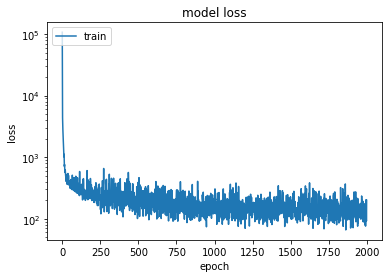

In [381]:
# Fit on training data
history = model.fit(x=temps, y=energies, epochs=2000, verbose=0,
                    callbacks=keras.callbacks.TerminateOnNaN())
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

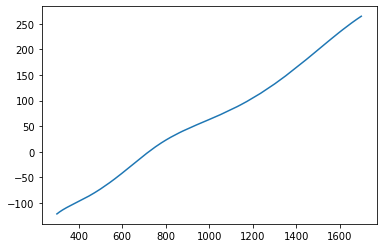

In [382]:
import matplotlib.pyplot as plt
plt.plot(temps, energies-model.predict(temps))

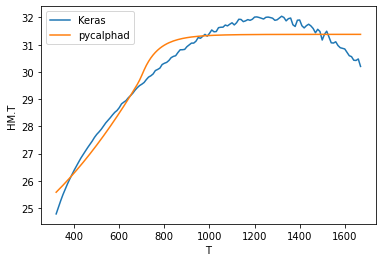

In [383]:
fine_temps = np.arange(300, 1700, 10)
fine_energies = np.array([float(dbf.symbols['GHSERZN'].xreplace({v.T: t})) for t in fine_temps])
gm_calphad = fine_energies
sm_calphad = -np.gradient(gm_calphad, fine_temps)
hm_calphad = gm_calphad + fine_temps * sm_calphad
cpm_calphad = np.gradient(hm_calphad, fine_temps)

gm_ml = model.predict(fine_temps)
sm_ml = -np.gradient(gm_ml, fine_temps)
hm_ml = gm_ml + fine_temps * sm_ml
cpm_ml = np.gradient(hm_ml, fine_temps)

plt.plot(fine_temps[2:-2], cpm_ml[2:-2], label='Keras')
plt.plot(fine_temps[2:-2], cpm_calphad[2:-2], label='pycalphad')
plt.ylabel('HM.T')
plt.xlabel('T')
plt.legend()

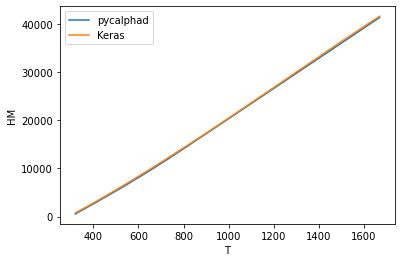

In [384]:
plt.plot(fine_temps[2:-2], hm_calphad[2:-2], label='pycalphad')
plt.plot(fine_temps[2:-2], hm_ml[2:-2], label='Keras')
plt.ylabel('HM')
plt.xlabel('T')
plt.legend()

In [385]:
model.weights

[<tf.Variable 'polynomial_crossing_189/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.08545507, -0.08088244],
        [ 0.09417036, -0.13370517]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_190/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.03616876, -0.00466451],
        [ 0.00690053, -0.31345287]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_191/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.06629524,  0.00079134],
        [ 0.00986493, -0.07514113]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_192/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.00022453,  0.00016883],
        [ 0.00042997, -0.00347712]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_193/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 6.6803940e-02,  1.1465766e-03],
        [ 9.9526529e-05, -2.7393818e-02]], dtype=float32)>,
 <tf.Variable 'polynomial_crossing_194/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.04982486, -0.00422104]